# Task 1. Databases

Included in the assignment you will find a csv file (`./artifacts/postings_february.csv.zip`)
containing basic information on real estates postings ingested daily over a month. Load the
data in a database you find appropriate. How complete is the data? Do you see any issue?

We are interested in the following:

- average price per square meter per category
- number of postings online, per category
- number of postings created over the first and last day
- relative difference on postings created daily; do you see any pattern?
- a query reporting when an alert system monitoring the postings created daily should have fired

Make sure to provide in the results all the artifacts you generate and a readme on how to
run, for us to be able to reproduce in the most automated way.

In [1]:
# imports

import pandas as pd
import numpy as np
import datetime
import os

import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [2]:
ls

Dockerfile   data/        sql-scripts/ task1.html   task1.ipynb


### 1. Read file

In [3]:
df = pd.read_csv(r"data/postings_february.csv", parse_dates=["created_at"])

# created new columns from created_at for further analysis
df["created_date"] = df["created_at"].dt.date
df["created_time"] = df["created_at"].dt.time
df["created_hour"] = df["created_at"].dt.hour
df["created_weekday"] = df["created_at"].apply(lambda x: x.strftime('%A'))

print(df.shape)

df.head()
#df.tail()

(143027, 11)


,uuid,category,zip_code,price,area,created_at,status,created_date,created_time,created_hour,created_weekday
0,9c5d5ccc-6822-48bd-9590-6ca7695fb009,office,NaN,NaN,NaN,2021-02-27 17:47:31,REMOVED,2021-02-27,17:47:31,17,Saturday
1,498f4f33-f596-4499-8fc7-a3e2bb02e129,office,NaN,NaN,NaN,2021-02-27 17:47:31,REMOVED,2021-02-27,17:47:31,17,Saturday
2,57554554-639d-41e6-b83d-6f51ea053051,office,NaN,NaN,NaN,2021-02-27 17:47:32,REMOVED,2021-02-27,17:47:32,17,Saturday
3,0f6d8033-f252-475c-8ba8-846ccc68d2e3,house,35796,125000.0,80.0,2021-02-12 17:08:51,REMOVED,2021-02-12,17:08:51,17,Friday
4,c1caea71-02d4-470d-b382-92108560f454,office,NaN,NaN,NaN,2021-02-23 17:30:33,REMOVED,2021-02-23,17:30:33,17,Tuesday


### 2. Basic Analysis

From the first few rows, we can already see there are some missing values on the columns "zip_code", "price" and "area".  Let's check it for all the columns and let's also check the datatype, how many unique values in each column, potencial outliers, etc.

In [4]:
df.isna().sum()

uuid                   0
category               0
zip_code            8992
price              95581
area               13556
created_at             0
status                 0
created_date           0
created_time           0
created_hour           0
created_weekday        0
dtype: int64

In [5]:
df.dtypes

uuid                       object
category                   object
zip_code                   object
price                     float64
area                      float64
created_at         datetime64[ns]
status                     object
created_date               object
created_time               object
created_hour                int64
created_weekday            object
dtype: object

In [6]:
df.nunique()

uuid               143027
category                6
zip_code             6938
price                6429
area                13665
created_at          70022
status                  3
created_date           28
created_time        13225
created_hour            6
created_weekday         7
dtype: int64

In [7]:
# not all the price has corresponding area

df.describe()

,price,area,created_hour
count,4.744600e+04,129471.000000,143027.000000
mean,4.199551e+05,378.467347,17.689101
std,1.737207e+06,3218.948533,0.933066
min,2.999000e+02,1.000000,17.000000
25%,1.650000e+05,56.100000,17.000000
50%,3.020000e+05,80.930000,17.000000
75%,4.900000e+05,140.000000,18.000000
max,3.600000e+08,647210.000000,22.000000


In [8]:
print("Fisrt posting", df["created_at"].min())
print("Last posting", df["created_at"].max())

# check that the uuid indeed is unique
assert df.uuid.nunique() == df.uuid.count()

Fisrt posting 2021-02-01 17:02:57
Last posting 2021-02-28 19:13:27


In [9]:
print("Unique category values:", df.category.unique())
print("Unique status values  :", df.status.unique())

Unique category values: ['office' 'house' 'apartment' 'retail' 'temporary_living' 'industrial']
Unique status values  : ['REMOVED' 'ONLINE' 'PENDING']


#### Observations

1. Indeed the data contains postings from Feb 2021, and uuid is unique. 
2. There are missing values in 3 columns columns "zip_code", "price" and "area".
3. There are 6 different categories (['office' 'house' 'apartment' 'retail' 'temporary_living' 'industrial']), 3 different status(['REMOVED' 'ONLINE' 'PENDING']), 28 created_date (Feb 2021 has 28 days)
4. Data ingestion hour (created_hour) is between 17:00h and 23:00h. 
5. From the describe table, both price and area seems to have outliers. The max value is way bigger than the 75% percentile. 


### 3. More in-depth analysis

Now we have a basis understanding of the data, let's check it more in depth. 

### 3.1 univariate analysis

In [10]:
def univariate_analysis(df, col, sort_by_posting=True):
    """
    giving the datafram and the column name, return value counts of the columns and its percentage
    sort_by_posting by default is True, change to false if you don't want the dataframe to be sorted by number of postings
    
    """
    total_postings = df.uuid.count()
    df_grouped = df.groupby(col).agg({"uuid": "count"}).reset_index()
    
    df_grouped.rename(columns = {'uuid': 'postings'}, inplace = True)
    df_grouped.sort_values('postings', ascending=False, inplace=sort_by_posting)
    
    df_grouped["%_posting"] = round(df_grouped.postings/total_postings * 100, 4)
    return df_grouped

#### 3.1.1 Status

There are more "REMOVED" posts (75%) than "ONLINE" posts (25%), only 6 postings are "PENDING".
<font color='red'>Is it normal to have more "REMOVED" than "ONLINE"? What cause posting to be "PENDING"?  </font>

In [11]:
univariate_analysis(df, "status")

,status,postings,%_posting
2,REMOVED,107035,74.8355
0,ONLINE,35986,25.1603
1,PENDING,6,0.0042


In [12]:
# Let's check the 6 pending ones. 

df[df.status=="PENDING"]

,uuid,category,zip_code,price,area,created_at,status,created_date,created_time,created_hour,created_weekday
54180,39760fda-947f-4d97-8638-3b574389ded5,house,NaN,NaN,NaN,2021-02-25 19:15:35,PENDING,2021-02-25,19:15:35,19,Thursday
58254,3dbb2de6-07d7-4506-a073-68e7a56464e0,house,NaN,NaN,NaN,2021-02-22 18:02:46,PENDING,2021-02-22,18:02:46,18,Monday
63454,2d965bac-1df0-4d2a-8753-322a4643294f,apartment,NaN,NaN,NaN,2021-02-22 18:30:14,PENDING,2021-02-22,18:30:14,18,Monday
75308,aaa8da4e-a6f1-4ffa-8fa2-085464c6c24e,house,NaN,NaN,NaN,2021-02-25 20:02:37,PENDING,2021-02-25,20:02:37,20,Thursday
87949,5c245dd9-e88f-42d9-a939-32d8448f0e27,apartment,NaN,NaN,NaN,2021-02-04 17:13:12,PENDING,2021-02-04,17:13:12,17,Thursday
106800,94658277-5cd8-4ba1-8b05-7e5b80b10af3,apartment,NaN,NaN,NaN,2021-02-28 17:22:13,PENDING,2021-02-28,17:22:13,17,Sunday


#### 3.1.2 category

Most of the posts are in the "apratment" and "house" categories

In [13]:
univariate_analysis(df, "category")

,category,postings,%_posting
0,apartment,79830,55.8146
1,house,28422,19.8718
3,office,15279,10.6826
5,temporary_living,12209,8.5362
2,industrial,5288,3.6972
4,retail,1999,1.3976


#### 3.1.3 zip_code

Top 5:
- 60329 Frankfurt
- 20457 Hamburg
- 20095 Hamburg
- 22761 Hamburg
- 17034 Neubrandenburg

Ideas, but out of the scope of this task: 

Next nice thing to do would be find the coordinates of the zip_codes and plot a heatmap to see the distrubution of zip_code, and see it by status, by category,etc. We could have a heatmap of avg price per square meter and have more visual way to see which zip_code (neighborhood) is more expensive.

In [14]:
univariate_analysis(df, "zip_code")[:5]

,zip_code,postings,%_posting
3754,60329,700,0.4894
1105,20457,672,0.4698
1087,20095,505,0.3531
1280,22761,457,0.3195
920,17034,373,0.2608


#### 3.1.4 created_date, created_hour, created_weekday

<font color='red'>There are only 22 postings on  2021-02-20. Did something go wrong that day?</font> 

In [15]:
df_created_date = univariate_analysis(df, "created_date")
df_created_date

,created_date,postings,%_posting
24,2021-02-25,10990,7.6839
4,2021-02-05,9090,6.3554
15,2021-02-16,7790,5.4465
18,2021-02-19,7665,5.3591
25,2021-02-26,7399,5.1731
11,2021-02-12,7334,5.1277
22,2021-02-23,7274,5.0858
1,2021-02-02,7130,4.9851
8,2021-02-09,6979,4.8795
3,2021-02-04,5869,4.1034


In [16]:
# uncomment to see the 22 postings from 2020-02-20.
# df[df["created_at"].dt.day == 20]

<Figure size 720x360 with 0 Axes>

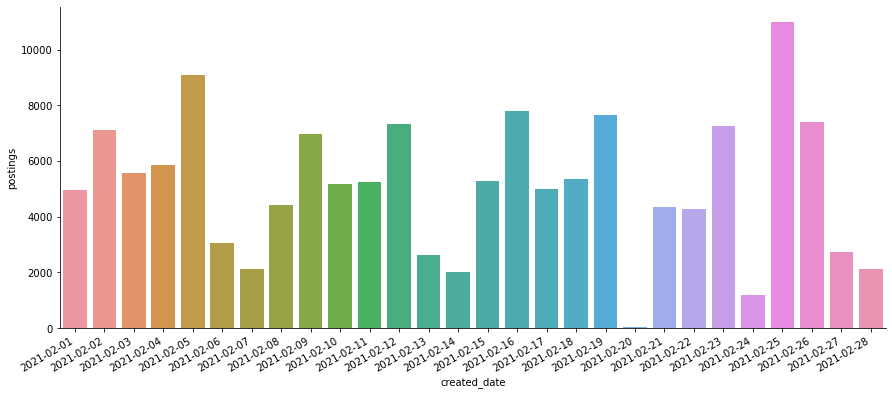

In [17]:
plt.figure(figsize=(10,5))
g = sns.catplot(x="created_date", 
                y="postings", 
                kind="bar", 
                data=univariate_analysis(df, "created_date", sort_by_posting=False), 
                aspect=2.5)
g.set_xticklabels(rotation=30, ha="right")

There are less volumns during the weekend. Friday seems to have most volumn (22%) following closely by Tuesday and Thrusday.

In [18]:
univariate_analysis(df, "created_weekday")

,created_weekday,postings,%_posting
0,Friday,31488,22.0154
5,Tuesday,29173,20.3968
4,Thursday,27473,19.2083
1,Monday,18956,13.2534
6,Wednesday,16924,11.8327
3,Sunday,10608,7.4168
2,Saturday,8405,5.8765


From the time, we can see that the data ingestion started at 17:00h and finish before 23:00h. Half of the data is ingested during the first hour.

In [19]:
print("Ealiest posting time", df["created_time"].min())
print("Lastest posting time", df["created_time"].max())

univariate_analysis(df, "created_hour")

Ealiest posting time 17:02:38
Lastest posting time 22:56:40


,created_hour,postings,%_posting
0,17,72356,50.5890
1,18,55430,38.7549
2,19,7546,5.2759
3,20,4191,2.9302
4,21,2055,1.4368
5,22,1449,1.0131


#### 3.1.6 Price, Area

It's alread mentioned before in the basis analysis session that both price and area seems to have <font color='red'>Outliers</font>. 
The max value is way bigger than the 75% percentile. 


In [20]:
df.describe()[["price", "area"]]

,price,area
count,4.744600e+04,129471.000000
mean,4.199551e+05,378.467347
std,1.737207e+06,3218.948533
min,2.999000e+02,1.000000
25%,1.650000e+05,56.100000
50%,3.020000e+05,80.930000
75%,4.900000e+05,140.000000
max,3.600000e+08,647210.000000


### 3.2 Outliers

It has to be confirmed, but I believe the unit for area is m2, it's highly unlikely that a **house or apartment** would have area about 100k or more. Also the price 360 millions for the apartment seems to be off. 

The minimum values,i.e. area=1 or price=299.9 are also suspicious.

In order to answer the first question "average price per square meter per category", I will only remove the 4 outliers with large area and price, the one with price=360000000, and the 3 with (df.area>=75000 and price>0), and the 25 outliers with area <=10 and price <=500.  

I'll leave that to the domain expert to confirm whether or not these criteries make sense or should be ammend.

<AxesSubplot:xlabel='area', ylabel='price'>

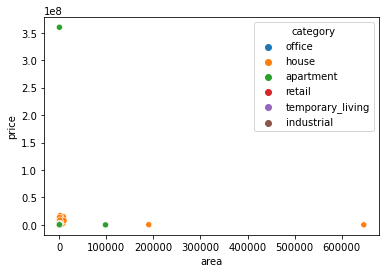

In [21]:
sns.scatterplot(x=df['area'],y=df['price'],hue=df['category'])

There are 23 postings with area=1 and price>0, and 2 postings with area 10 and price = 3790k.

Let's list few of them:

In [22]:
print(df[(df.area<=10) & (df.price>0)].shape)
df[(df.area<=10) & (df.price>0)].head()

(25, 11)


,uuid,category,zip_code,price,area,created_at,status,created_date,created_time,created_hour,created_weekday
19664,d7e140ef-cfe1-42a3-85c9-e369eaefec12,house,41462,639000.0,1.0,2021-02-25 18:50:34,REMOVED,2021-02-25,18:50:34,18,Thursday
25680,b3aa1a73-91af-448d-acb7-993185c3925b,house,93183,195000.0,1.0,2021-02-16 18:38:06,REMOVED,2021-02-16,18:38:06,18,Tuesday
34634,e0649e11-958a-4d23-8193-6c08c41af3ca,house,17111,4800.0,1.0,2021-02-01 18:08:19,REMOVED,2021-02-01,18:08:19,18,Monday
35110,b430adaa-ed4e-4218-833a-f7ad6a3128d7,house,51067,598000.0,1.0,2021-02-21 20:56:58,REMOVED,2021-02-21,20:56:58,20,Sunday
37632,f1e95b5c-3cf8-4f57-b0e6-e5977a2f070f,house,17166,195000.0,1.0,2021-02-15 18:10:24,REMOVED,2021-02-15,18:10:24,18,Monday


In [23]:
df[df.price<500]

,uuid,category,zip_code,price,area,created_at,status,created_date,created_time,created_hour,created_weekday
46549,7f44daac-3fd2-4b0f-884f-787c3b78f38a,house,38642,299.9,200.75,2021-02-07 17:28:46,REMOVED,2021-02-07,17:28:46,17,Sunday
86931,d10cd9b5-d4b6-46c0-9378-deda5201f373,house,37520,299.9,200.75,2021-02-07 17:28:45,REMOVED,2021-02-07,17:28:45,17,Sunday
132335,fe955750-098c-49fc-8e78-2e972fb1572a,house,07958,380.0,100.00,2021-02-13 17:49:02,REMOVED,2021-02-13,17:49:02,17,Saturday


In [24]:
df[df.price==360000000]

,uuid,category,zip_code,price,area,created_at,status,created_date,created_time,created_hour,created_weekday
84011,a9c613da-45ca-4555-853d-34e367d7ab32,apartment,61381,360000000.0,60.0,2021-02-21 20:50:48,ONLINE,2021-02-21,20:50:48,20,Sunday


In [25]:
df[(df.area>=75000) & (df.price>0)]

,uuid,category,zip_code,price,area,created_at,status,created_date,created_time,created_hour,created_weekday
58573,b95c3e3d-6357-44d4-9946-95035bd49109,house,08315,220000.0,647210.0,2021-02-25 19:38:44,ONLINE,2021-02-25,19:38:44,19,Thursday
95180,49b05a54-076f-443b-914e-2a38166db2d9,apartment,29451,85000.0,98000.0,2021-02-19 17:26:21,ONLINE,2021-02-19,17:26:21,17,Friday
130175,3a90728e-63f7-44c2-be79-6dd6adfc8d0f,house,96176,430000.0,190000.0,2021-02-18 18:30:01,REMOVED,2021-02-18,18:30:01,18,Thursday


Remove outliers and calculate price per square meter.

In [26]:
df["area"] = np.where(((df.area>=75000) & (df.price>0)), np.nan, df.area)
df["price"] = np.where(df.price==360000000, np.nan, df.price)

df["area"] = np.where(((df.area<=10) & (df.price>0)), np.nan, df.area)
df["price"] = np.where(df.price<=500, np.nan, df.price)

print("Posting with price", df[(df.price>0)].shape)
print("Posting with area", df[(df.area>0)].shape)

print("\nPosting with no price but area", df[(df.price.isna()) & (df.area>0)].shape)
print("Posting with no area but price", df[(df.area.isna()) & (df.price>0)].shape)

print("\nPosting with both price and area", df[(df.price>0) & (df.area>0)].shape)

df["price_sqt_m2"] = np.where((df.price>0) & (df.area>0), df.price/df.area, np.nan)
df["price_sqt_m2"].describe()


Posting with price (47440, 11)
Posting with area (129443, 11)

Posting with no price but area (83287, 11)
Posting with no area but price (1284, 11)

Posting with both price and area (46156, 11)


count    46156.000000
mean      3218.127491
std       2370.696688
min          2.892849
25%       1548.000000
50%       2768.869823
75%       4305.912596
max      49938.685561
Name: price_sqt_m2, dtype: float64

After removing the 4 outliers, we can see better the area - price scatterplot. 

<AxesSubplot:xlabel='area', ylabel='price'>

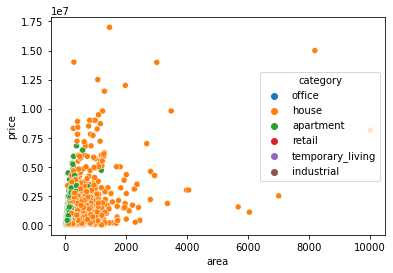

In [27]:
sns.scatterplot(x=df['area'],y=df['price'],hue=df['category'])

# Questions and Answers

### Question 1: average price per square meter per category

The price per square meter is only informed for apartment and house. In avarage apartment has higher price per square meter. 

In [28]:
df.groupby("category").agg({"price_sqt_m2": "mean"}).reset_index()

,category,price_sqt_m2
0,apartment,3975.806472
1,house,2542.844741
2,industrial,NaN
3,office,NaN
4,retail,NaN
5,temporary_living,NaN


<AxesSubplot:xlabel='category', ylabel='price_sqt_m2'>

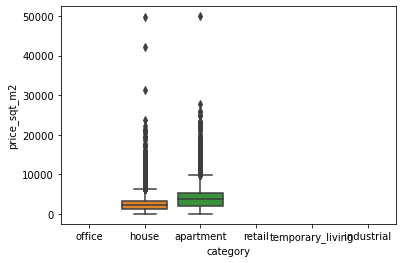

In [29]:
sns.boxplot(x=df["category"], y=df['price_sqt_m2'])

### Question 2: number of postings online, per category

50% ONLINE postings are for apartment.

In [30]:
# df[df.status=="ONLINE"].groupby("category").agg({"uuid": "count"}).reset_index()

In [31]:
univariate_analysis(df[df.status=="ONLINE"], "category")

,category,postings,%_posting
0,apartment,18154,50.4474
1,house,7964,22.1308
3,office,5515,15.3254
5,temporary_living,2136,5.9356
2,industrial,1522,4.2294
4,retail,695,1.9313


### Qustion 3: number of postings created over the first and last day

In [32]:
df[(df["created_at"].dt.day == 1) | (df["created_at"].dt.day == 28)].groupby(["created_date"]).agg({"uuid": "count"}).reset_index()

,created_date,uuid
0,2021-02-01,4967
1,2021-02-28,2136


### Qustion 4: relative difference on postings created daily; do you see any pattern?

- There is usually a big decrease on Saterday (2021-02-06,  2021-02-13, 2021-02-20, 2021-02-27).
- The volumn on 24th and 25th seem a bit unsually, it looks like some of the ingestion from 24th are done on the 25th instead?
- As we have already seen before, Friday seems to have most volumn following closely by Tuesday and Thrusday.

In [33]:
df_created_date = df.groupby("created_date").agg({"uuid": "count"}).reset_index()
df_created_date["uuid_previous_day"] = df_created_date.shift(1)["uuid"]
df_created_date["diff_postings"] = df_created_date["uuid"] - df_created_date["uuid_previous_day"]
df_created_date["%_diff_postings"] = round(df_created_date["diff_postings"]/df_created_date["uuid_previous_day"]*100, 2)
#df_created_date

<Figure size 576x216 with 0 Axes>

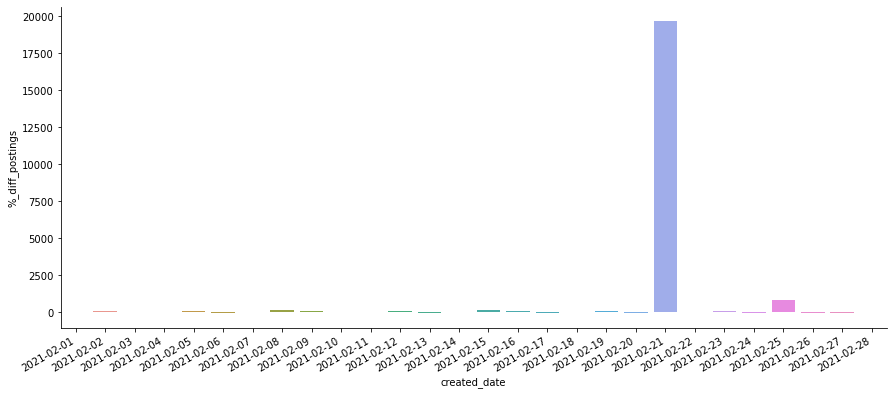

In [34]:
plt.figure(figsize=(8,3))
g = sns.catplot(x="created_date", y="%_diff_postings", data=df_created_date,
                kind="bar", aspect=2.5)
g.set_xticklabels(rotation=30, ha="right")

as reference, I'll leave the plot with daily change (absolute volumn change compared to previous day) below for comparison.

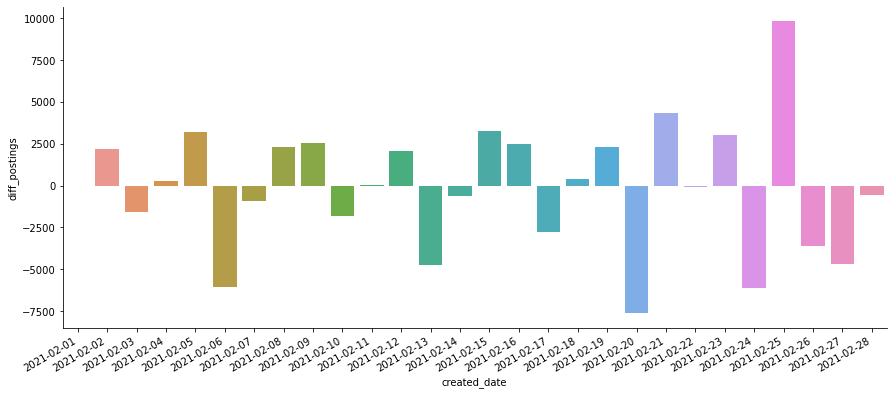

In [35]:
g = sns.catplot(x="created_date", y="diff_postings", data=df_created_date,
                kind="bar", aspect=2.5)
g.set_xticklabels(rotation=30, ha="right")

And the daily volumn.

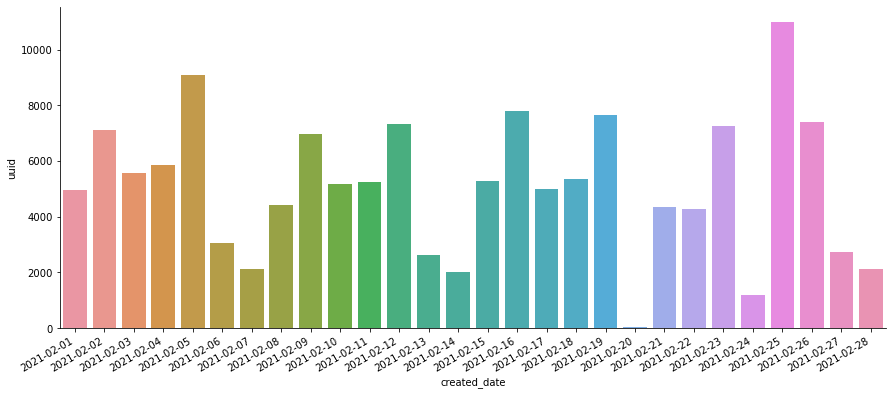

In [36]:
g = sns.catplot(x="created_date", y="uuid", data=df_created_date,
                kind="bar", aspect=2.5)
g.set_xticklabels(rotation=30, ha="right")


### Question 5: a query reporting when an alert system monitoring the postings created daily should have fired

One alert could be if the posting volumn in absolute number is lower or higher than expected, then fire a alert. 

In [37]:
df_created_date[(df_created_date.uuid<100) | (df_created_date.uuid>10000)]

,created_date,uuid,uuid_previous_day,diff_postings,%_diff_postings
19,2021-02-20,22,7665.0,-7643.0,-99.71
24,2021-02-25,10990,1177.0,9813.0,833.73


Another alert could be when relative volumn dropped or increase more than expected. 

In [38]:
# define the threahold for unexpected drops or increases.

lower_bound = -70  # if volumn drop over 70%
upper_bound = 200  # if volumn increase over 200%

df_created_date[(df_created_date["%_diff_postings"]< lower_bound) | (df_created_date["%_diff_postings"]>upper_bound)]

,created_date,uuid,uuid_previous_day,diff_postings,%_diff_postings
19,2021-02-20,22,7665.0,-7643.0,-99.71
20,2021-02-21,4348,22.0,4326.0,19663.64
23,2021-02-24,1177,7274.0,-6097.0,-83.82
24,2021-02-25,10990,1177.0,9813.0,833.73


# Additional

Let's check the daily postings by status and categories.

In [39]:
df_count_online = df[df.status=="ONLINE"].groupby(["created_date", "category"]).agg({"uuid": "count"}).reset_index()
df_count_pending = df[df.status=="PENDING"].groupby(["created_date", "category"]).agg({"uuid": "count"}).reset_index()
df_count_removed = df[df.status=="REMOVED"].groupby(["created_date", "category"]).agg({"uuid": "count"}).reset_index()

df_count_all = df.groupby(["created_date", "category", "status"]).agg({"uuid": "count"}).reset_index()
df_count_all

,created_date,category,status,uuid
0,2021-02-01,apartment,ONLINE,517
1,2021-02-01,apartment,REMOVED,2603
2,2021-02-01,house,ONLINE,255
3,2021-02-01,house,REMOVED,665
4,2021-02-01,industrial,ONLINE,79
...,...,...,...,...
333,2021-02-28,office,REMOVED,325
334,2021-02-28,retail,ONLINE,10
335,2021-02-28,retail,REMOVED,28
336,2021-02-28,temporary_living,ONLINE,22


Postings per status

<Figure size 720x360 with 0 Axes>

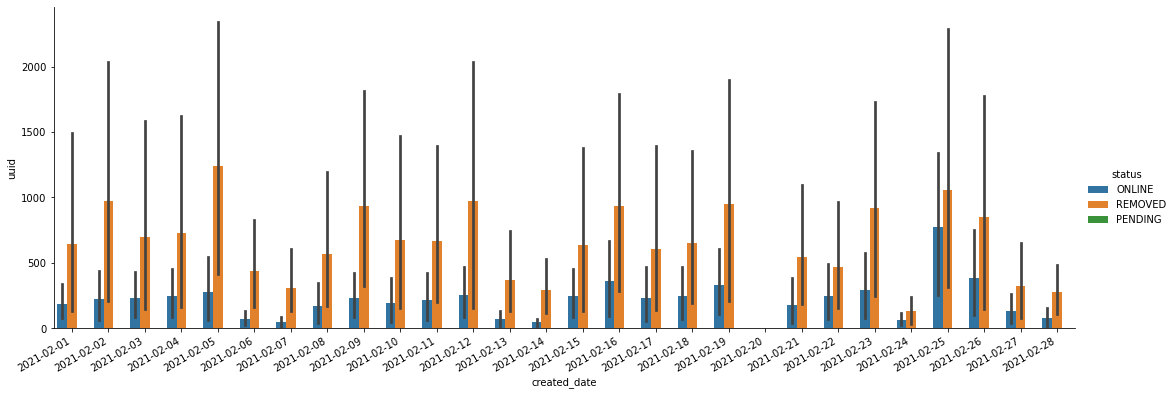

In [40]:
plt.figure(figsize=(10,5))
g = sns.catplot(x="created_date", y="uuid", hue="status", kind="bar", data=df_count_all, aspect=3)
#g = sns.catplot(x="created_date", y="uuid", hue="status", kind="bar", row="category", data=df_count_all, aspect=3)
g.set_xticklabels(rotation=30, ha="right")

Postings with status PENDING

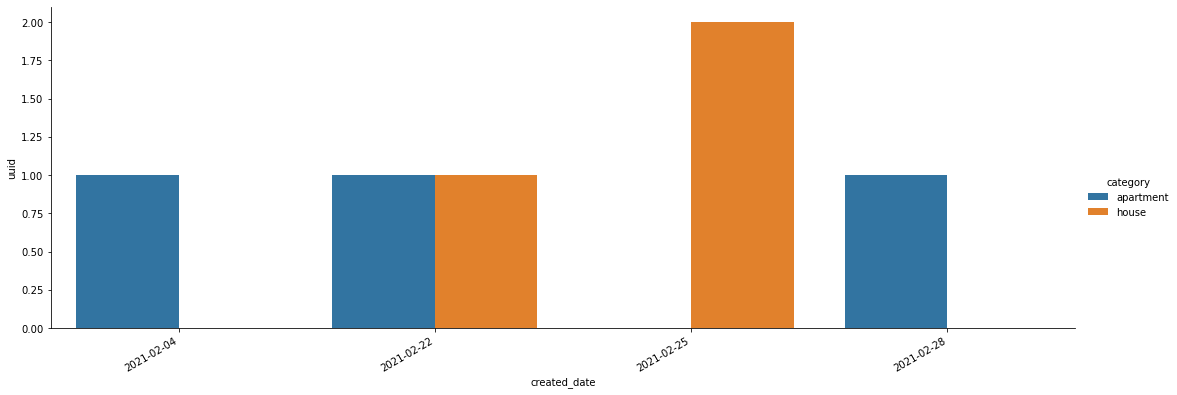

In [41]:
g = sns.catplot(x="created_date", y="uuid", hue="category", kind="bar", data=df_count_pending, aspect=3)
g.set_xticklabels(rotation=30, ha="right")

Postings with status REMOVED

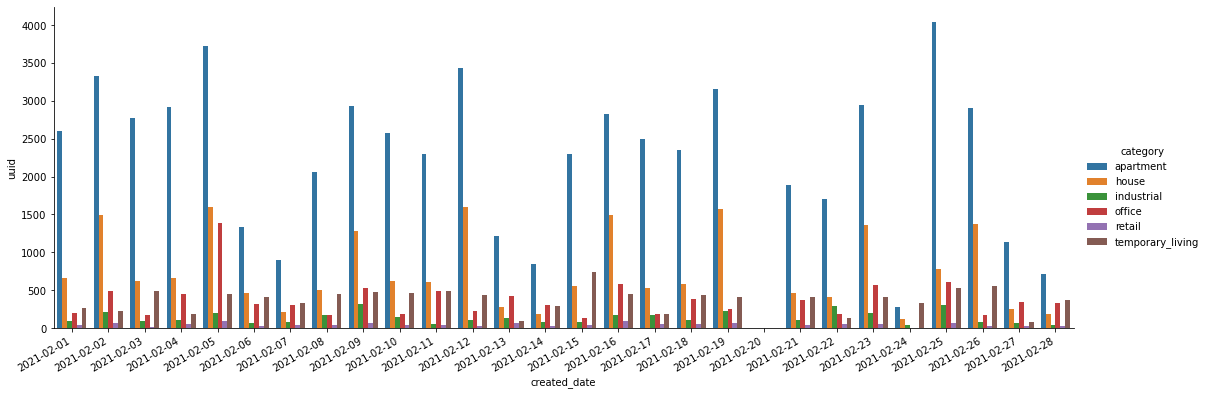

In [42]:
g = sns.catplot(x="created_date", y="uuid", hue="category", kind="bar", data=df_count_removed, aspect=3)
g.set_xticklabels(rotation=30, ha="right")

Posting with status ONLINE

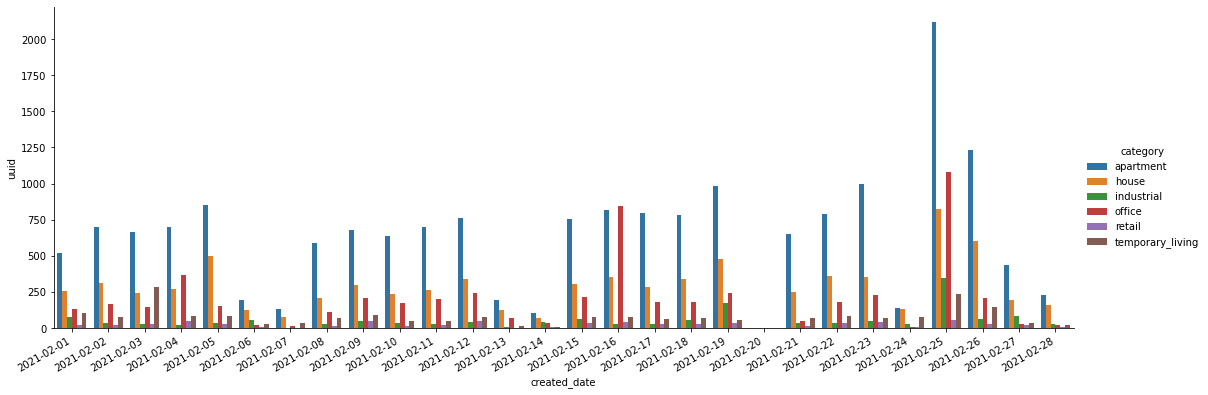

In [43]:
g = sns.catplot(x="created_date", y="uuid", hue="category", kind="bar", data=df_count_online, aspect=3)
g.set_xticklabels(rotation=30, ha="right")